#### Code for introducing Voltage Dependent Theta Neuron Model into Low Rank Connectivity SNNs  


In [85]:
import matplotlib.pyplot as plt
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [135]:
class LowRankSNN:
    # CONSTANTS
    G_L_E = 0.08
    G_L_I = 0.1
    G_P= [0.004069, 0.02672, 0.003276, 0.02138] #g_peak:[E←E, E←I, I←E, I←I]
    V_T = -55
    V_R = -62
    REV_E = 0
    REV_I = -70
    BIAS = V_T - V_R #Bias current
    C0 = 2/(V_T-V_R)
    C1 = (2*REV_E-V_R-V_T)/(V_T-V_R)
    C2 = (2*REV_I-V_R-V_T)/(V_T-V_R)

    def __init__(self,N_E=1000,N_I=200,RS= 1,IS=100,taud_E=2,taud_I=5) -> None:
        self.N_E = N_E
        self.N_I = N_I
        self.RS = RS
        self.IS = IS
        self.taud_E = taud_E
        self.taud_I = taud_I
        self.conn = np.zeros((N_E+N_I,N_E+N_I))
        self.added_lowrank = False
        self.added_random = False
        

    def show(self):
        print('Network Settings')
        print('==========================================')
        print('Number of Neurons: ', self.N_E+self.N_I)
        print('Number of Excitatory Units: ', self.N_E)
        print('Number of Inhibitory Units: ', self.N_I)
        # full_w = torch.mm(self.W, self.mask) #包含兴奋和抑制性信息的连接矩阵
        # full_w = self.W * self.mask
        zero_w = (self.conn == 0).sum().item()
        # pos_w = (self.conn > 0).sum().item()
        # neg_w = (full_w < 0 ).sum().item()
        print('Zero Weights occupy: %2.2f %%'%(zero_w/(self.N**2)*100))
        # print('Positive Weights occupy: %2.2f %%'%(pos_w/(self.N**2)*100))
        # print('Negative Weights occupy: %2.2f %%'%(neg_w/(self.N**2)*100))

    def show_conn(self):
        full_w = self.conn #包含兴奋和抑制性信息的连接矩阵
        # let the weight from Inhibitory be negative value
        full_w[:,self.N_E:self.N_E+self.N_I] = -full_w[:,self.N_E:self.N_E+self.N_I]
        colors = [(0, 0, 1), (1, 1, 1), (1, 0, 0)]  # 蓝 -> 白 -> 红
        cmap_name = 'gradient_div_cmap'
        gradient_cm = mcolors.LinearSegmentedColormap.from_list(cmap_name, colors, N=100)  # N=100 使渐变更加平滑
        plt.imshow(full_w,cmap=gradient_cm,vmax=0.005,vmin=-0.005)
        plt.colorbar()
        plt.title('Connectivity Matrix')
        plt.xlabel('From')
        plt.xticks(np.arange(0,len(full_w)+1,200))
        plt.ylabel('To')
        plt.yticks(np.arange(0,len(full_w)+1,200))
        plt.gca().xaxis.set_ticks_position('top')
        plt.gca().xaxis.set_label_position('top')
        plt.show()
        

    def add_random(self,conn_rand):
        self.conn_random = conn_rand
        self.conn += conn_rand*self.RS
        self.added_random = True
        print('Random connection has been added.')
        return

    def remove_random(self):
        if not self.added_random:
            print('There is no random connection added.')
            return
        self.conn -= self.conn_random
        del self.conn_random
        self.added_random = False
        print('Random connection has been removed.')
        return

    def add_lowrank(self,conn_LR, W_out):
        self.conn_lowrank = conn_LR
        self.conn += conn_LR
        self.W_out = W_out
        self.added_lowrank = True
        print('Low Rank connection and readout vector have been added.')
        return

    def remove_lowrank(self):
        if not self.added_lowrank:
            print('There is no Low Rank Connectivity added.')
            return
        self.conn -= self.conn_lowrank
        del self.conn_lowrank
        del self.W_out
        self.added_lowrank = False
        print('Low Rank connection and readout vector have been removed.')

    def V2theta(self,V):
        V_R = LowRankSNN.V_R
        V_T = LowRankSNN.V_T
        return 2*np.arctan((V-(V_R+V_T)/2)*2/(V_T-V_R))

    def theta2V(self,theta):
        V_R = LowRankSNN.V_R
        V_T = LowRankSNN.V_T
        return (V_T+V_R)/2+(V_T-V_R)/2*np.tan(theta/2)

    def simulate(self,dt,Input):

        if self.conn_lowrank.shape == self.conn_random.shape:
            print('Low-rank connectivity is added to all the connections')

        G_P = LowRankSNN.G_P
        G_L_E = LowRankSNN.G_L_E
        G_L_I = LowRankSNN.G_L_I
        C0 = LowRankSNN.C0
        C1 = LowRankSNN.C1
        C2 = LowRankSNN.C2
        conn_EE = self.conn[:self.N_E,:self.N_E]
        conn_IE = self.conn[self.N_E:self.N_E+self.N_I,:self.N_E]
        conn_EI = self.conn[:self.N_E,self.N_E:self.N_E+self.N_I]
        conn_II = self.conn[self.N_E:self.N_E+self.N_I,self.N_E:self.N_E+self.N_I]
        V = np.zeros_like(Input)
        phase = np.zeros_like(Input)
        g = np.zeros_like(Input)
        g_EE = np.delete(np.zeros_like(Input),range(self.N_I),axis=0)
        g_IE = np.delete(np.zeros_like(Input),range(self.N_E),axis=0)
        g_EI = np.delete(np.zeros_like(Input),range(self.N_I),axis=0)
        g_II = np.delete(np.zeros_like(Input),range(self.N_E),axis=0)
        spk = np.zeros_like(Input)

        for step, inputs in enumerate(Input.T): #for every time step
            if step == 0: continue
            # print(step)
            # print(inputs.shape)
            # Calculate Synaptic Conductance
            g_EE[:,step] = g_EE[:,step-1] + \
                1/self.taud_E*(-g_EE[:,step-1]+ \
                G_P[0]*conn_EE@spk[:self.N_E,step-1])*dt
            g_EI[:,step] = g_EI[:,step-1] + \
                1/self.taud_E*(-g_EI[:,step-1]+ \
                G_P[1]*conn_EI@spk[self.N_E:self.N_E+self.N_I,step-1])*dt
            g_IE[:,step] = g_IE[:,step-1] + \
                1/self.taud_I*(-g_IE[:,step-1]+ \
                G_P[2]*conn_IE@spk[:self.N_E,step-1])*dt
            g_II[:,step] = g_II[:,step-1] + \
                1/self.taud_I*(-g_II[:,step-1]+ \
                G_P[3]*conn_II@spk[self.N_E:self.N_E+self.N_I,step-1])*dt
            # Calculate the comprehensive Synaptic Conductance
                # For Excitatory Neurons
            g[:self.N_E,step] = g[0:self.N_E,step-1] + \
                1/self.taud_E*(-g[0:self.N_E,step-1]+ \
                G_P[0]*conn_EE@spk[:self.N_E,step-1]+ \
                G_P[1]*conn_EI@spk[self.N_E:self.N_E+self.N_I,step-1])*dt
                # For Inhibitory Neurons
            g[self.N_E:self.N_E+self.N_I,step] = g[self.N_E:self.N_E+self.N_I,step-1] + \
                1/self.taud_I*(-g[self.N_E:self.N_E+self.N_I,step-1]+ \
                G_P[2]*conn_IE@spk[:self.N_E,step-1]+ \
                G_P[3]*conn_II@spk[self.N_E:self.N_E+self.N_I,step-1])*dt

            # Calculate Membrane Voltage (Phase)
            # For Excitatory Neurons
            phase_pre_E = phase[:self.N_E,step-1]
            phase[:self.N_E,step] = phase_pre_E + (-G_L_E*np.cos(phase_pre_E)+C0*(1+np.cos(phase_pre_E))*inputs[:self.N_E]+g_EE[:,step]*(C1*(1+np.cos(phase_pre_E))-\
                np.sin(phase_pre_E))+g_EI[:,step]*(C2*(1+np.cos(phase_pre_E))-np.sin(phase_pre_E)))*dt
            # For Inhibitory Neurons
            phase_pre_I = phase[self.N_E:self.N_E+self.N_I,step-1]
            phase[self.N_E:self.N_E+self.N_I,step] = phase_pre_I + (-G_L_I*np.cos(phase_pre_I)+C0*(1+np.cos(phase_pre_I))*inputs[self.N_E:self.N_E+self.N_I]+g_IE[:,step]*(C1*(1+np.cos(phase_pre_I))-\
                np.sin(phase_pre_I))+g_II[:,step]*(C2*(1+np.cos(phase_pre_I))-np.sin(phase_pre_I)))*dt

            # Store the firing time
            spk[:,step] = (phase[:,step] >= np.pi).astype(int)
            

        if self.conn_lowrank.shape == self.conn_random.shape:
            Out = np.dot(g.T,self.W_out)/(self.N_E+self.N_I) #Size of g:(N,time), Size of W_out: (N,1)
        V = self.theta2V(phase)
        return Out, V, g, spk



In [136]:
a = np.array([[1,1],
              [2,2]])
b = np.array([[0,1],
              [2,2]])
print(a@b)

[[2 3]
 [4 6]]


Low Rank connection and readout vector have been added.
Random connection has been added.


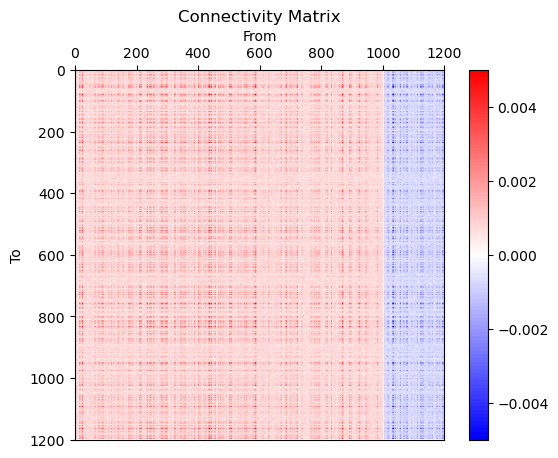

In [137]:
# Initialiazation
LRSNN = LowRankSNN(N_E=1000,N_I=200,RS= 1,IS=100,taud_E=2,taud_I=5)

# Go_NoGo Task
# Prepare the Stimuli and Readout Vector
temp = np.random.rand(1,LRSNN.N_E+LRSNN.N_I) #Size (1,N_E) for Sti_go and nogo #这里我想试试把Low Rank加到整个网络上
# print(temp)
Sti_go = temp.copy()
Sti_nogo = temp.copy()
W_out = temp.copy()
Sti_go[Sti_go>1/3] = 0
Sti_nogo[Sti_nogo<1/3] = 0
Sti_nogo[Sti_nogo>2/3] = 0
W_out[W_out<2/3] = 0
# print(np.nonzero(Sti_go)[0])
# print(len(np.nonzero(Sti_go)[0]))

# Use Gamma Distribution to generate Stimuli and Readout Vector
# Sti_go[Sti_go!=0] = np.random.gamma(1,1,len(np.nonzero(Sti_go)[0])) #random.gamma(shape, scale=1.0, size=None),这个地方的Gamma分布及其参数选取需要进一步讨论
# Sti_nogo[Sti_nogo!=0] = np.random.gamma(1,1,len(np.nonzero(Sti_nogo)[0]))
# W_out[W_out!=0] = np.random.gamma(1,1,len(np.nonzero(W_out)[0]))
# W_out = np.transpose(W_out) #Size (N_E,1)
# # Low Rank Connectivity (Rank = 1)
# conn_LR = W_out*Sti_go/(LRSNN.N_E+LRSNN.N_I) # 为什么除以神经元总数?
# # Random Connectivity
# conn_rand = np.random.gamma(1,1,(LRSNN.N_E+LRSNN.N_I,LRSNN.N_E+LRSNN.N_I)) #这里的Gamma分布取值也需要讨论

# Use Folded Gaussian Distribution to generate Stimuli and Readout Vector
std_Sti = 2. #Standerd Deviration of Stimuli
std_Wout = 2. #Standerd Deviration of readout matrix
Sti_go[Sti_go!=0] = np.abs(np.random.normal(0,std_Sti,len(np.nonzero(Sti_go)[0]))) 
Sti_nogo[Sti_nogo!=0] = np.abs(np.random.normal(0,std_Sti,len(np.nonzero(Sti_nogo)[0])))
W_out[W_out!=0] = np.abs(np.random.normal(0,std_Wout,len(np.nonzero(W_out)[0])))
W_out = np.transpose(W_out) #Size (N,1)
# Low Rank Connectivity (Rank = 1)
conn_LR = W_out*Sti_go/(LRSNN.N_E+LRSNN.N_I) # 为什么除以神经元总数?
# Random Connectivity
conn_rand = np.abs(np.random.normal(0,1/(LRSNN.N_E+LRSNN.N_I),(LRSNN.N_E+LRSNN.N_I,LRSNN.N_E+LRSNN.N_I))) #这里的Gamma分布取值也需要讨论

# Assemble the Network
LRSNN.add_lowrank(conn_LR, W_out)
LRSNN.add_random(conn_rand)

# Show the Network information before simulaiton
LRSNN.show_conn()



In [138]:
dt = 0.01 #(ms/step)
T_pre = 5 # length of time before sti (ms)
T_sti = 10 # length of time for sti (ms)
T_after = 15 # length of time after sti (ms)
T = T_pre+T_sti+T_after # length of Period time (ms): 30ms

Input_go = np.zeros((LRSNN.N_E+LRSNN.N_I,int(T/dt))) #size:(N,time)
Input_go[:,int(T_pre/dt):int((T_pre+T_sti)/dt)] = Sti_go.T
Input_nogo = np.zeros((LRSNN.N_E+LRSNN.N_I,int(T/dt)))
Input_nogo[:,int(T_pre/dt):int((T_pre+T_sti)/dt)] = Sti_nogo.T

# Simulation
Out_go, V_go, g_go, spk_go = LRSNN.simulate(dt,Input_go)
Out_nogo, V_nogo, g_nogo, spk_nogo = LRSNN.simulate(dt,Input_nogo)


Low-rank connectivity is added to all the connections
Low-rank connectivity is added to all the connections


In [139]:
# Draw the results

In [140]:
print({'a':1,'b':2})

{'a': 1, 'b': 2}
